# 前置設定

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import random
from scipy.interpolate import make_interp_spline

from drive.MyDrive.iirlab.topic.LSAN.LSANori.trainer import *
from drive.MyDrive.iirlab.topic.LSAN.LSANori.transformer import *
from drive.MyDrive.iirlab.topic.LSAN.LSANori.dataset import *
from drive.MyDrive.iirlab.topic.LSAN.LSANori.LSAN import *

# 滾動式預測

## 跑模型

In [ ]:
with open('/content/drive/MyDrive/iirlab/topic/LSAN/LSANori/model_inputs/rolling_prediction/29_39/rp_vlength.pickle','rb') as f:
  data = pickle.load(f)
  visit = data[0]
  label = data[1]
  value = data[3]
  dataset = Dataset(visit, label, value)

time_interval = '12_with_gap_6/18_39'
with open('/content/drive/MyDrive/iirlab/topic/trimmed_pickle/' + time_interval + '/final_test.pickle','rb') as f:
  data = pickle.load(f)
  visit = data[0]
  label = data[1]
  value = data[3]
  dataset = Dataset(visit, label, value)

In [ ]:
output_path = '/content/drive/MyDrive/iirlab/topic/LSAN/LSANori/output/result.txt'
hidden = 256 
layers = 8
attn_heads = 8 
dropout = 0.1
batch_size = 12
epochs = 10
num_workers = 2
with_cuda = 1
lr = 0.0001
adam_weight_decay = 0.01 ###
adam_beta1 = 0.9
adam_beta2 = 0.999
model_path = '/content/drive/MyDrive/iirlab/topic/LSAN/LSANori/model_parameters/0_51.6_models.pth'

In [ ]:
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=dataset.collate_fn,shuffle=False)
embedding_dim = hidden

test_model = LSAN(51, embedding_dim, transformer_hidden = hidden, attn_heads = attn_heads, transformer_dropout = dropout, transformer_layers = layers) 
test_model.load_state_dict(torch.load(model_path))
test_model.eval()

LSAN_test = LSAN_trainer(test_model, train_dataloader=data_loader, validate_dataloader=data_loader, test_dataloader=data_loader, with_cuda=with_cuda, lr=lr, output_dir=output_path)
LSAN_test.test(0, show = False, output = 0)

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.0196e-01,  ...,  1.0000e+00,
           1.0746e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.5814e-01,  ...,  1.0000e+00,
           2.1492e-04,  1.0000e+00],
         ...,
         [ 1.7612e-02, -9.9984e-01,  9.7640e-01,  ...,  9.9306e-01,
           1.0950e-01,  9.9399e-01],
         [-8.3182e-01, -5.5504e-01,  7.5651e-01,  ...,  9.9304e-01,
           1.0960e-01,  9.9398e-01],
         [-9.1649e-01,  4.0007e-01, -7.2582e-02,  ...,  9.9303e-01,
           1.0971e-01,  9.9396e-01]]])
Testing epoch:0 auc:0.7969184604161581 precision:0.8012422360248447 recall:0.8410757946210269 F1:0.8206759443339959
Testing loss : 0.5066185134806132


0.5066185134806132

In [ ]:
with open('/content/drive/MyDrive/iirlab/topic/LSAN/LSANori/model_inputs/rolling_prediction/29_39/pl.pickle','rb') as f:
  patientList = pickle.load(f)

df = pd.read_csv('/content/drive/MyDrive/iirlab/topic/LSAN/LSANori/output/rp_vlength_result.csv')
df = pd.concat([df, pd.DataFrame(patientList, columns = ['patient code'])], axis = 1)
df.to_csv('/content/drive/MyDrive/iirlab/topic/LSAN/LSANori/output/rp_vlength_result_with_patient_code.csv', index = False)

## 畫圖

In [3]:
rolling = pd.read_csv("/content/drive/MyDrive/iirlab/topic/LSAN/LSANori/output/rp_result_with_patient_code.csv").to_numpy()
# rolling = pd.read_csv("/content/drive/MyDrive/iirlab/topic/LSAN/LSANori/output/rp_vlength_result_with_patient_code.csv").to_numpy()

選出模型預測機率持續上升，最終模型判斷為有AKI，且確實有AKI的病人。

In [ ]:
selected_rolling = []
check = 0
for i in range(len(rolling)):
    if int(rolling[i][12]) == 1:
      check = 0
      for j in range(11):
          if rolling[i][j] < rolling[i][j+1]:
              check += 1
      if check >= 10 and rolling[i][11] >= 0.5:
          selected_rolling.append(i)
print(selected_rolling)

[691, 1041, 2780, 4455]


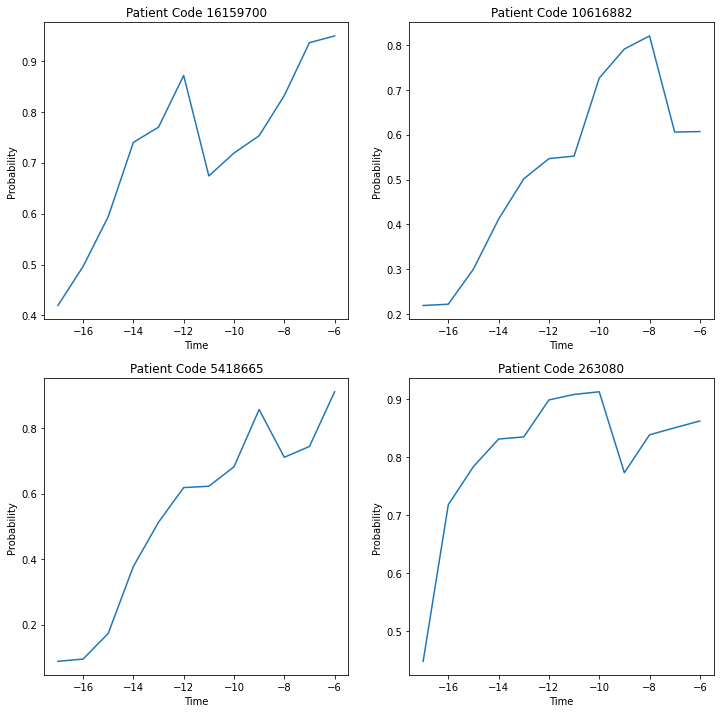

In [ ]:
time = [-17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6]
fig = plt.figure(figsize = (12, 12))

plt1 = fig.add_subplot(2,2,1)
plt1.set_title('Patient Code ' + str(int(rolling[selected_rolling[0]][13])))
plt1.set_xlabel('Time')
plt1.set_ylabel('Probability')
plt1.plot(time, rolling[selected_rolling[0]][0:12])

plt2 = fig.add_subplot(2,2,2)
plt2.set_title('Patient Code ' + str(int(rolling[selected_rolling[1]][13])))
plt2.set_xlabel('Time')
plt2.set_ylabel('Probability')
plt2.plot(time, rolling[selected_rolling[1]][0:12])

plt3 = fig.add_subplot(2,2,3)
plt3.set_title('Patient Code ' + str(int(rolling[selected_rolling[2]][13])))
plt3.set_xlabel('Time')
plt3.set_ylabel('Probability')
plt3.plot(time, rolling[selected_rolling[2]][0:12])

plt4 = fig.add_subplot(2,2,4)
plt4.set_title('Patient Code ' + str(int(rolling[selected_rolling[3]][13])))
plt4.set_xlabel('Time')
plt4.set_ylabel('Probability')
plt4.plot(time, rolling[selected_rolling[3]][0:12])

選出模型預測直敘下降 最後判斷為沒有AKI且真的沒有AKI的病人

In [ ]:
selected_rolling = []
check = 0
for i in range(len(rolling)):
    if int(rolling[i][12]) == 0:
      check = 0
      for j in range(11):
          if rolling[i][j] > rolling[i][j+1] and rolling[i][j] < 0.7:
              check += 1
      if check >= 10 and rolling[i][11] <= 0.5:
        print(rolling[i])
        selected_rolling.append(i)
print(selected_rolling)

[6.85217440e-01 6.82504117e-01 6.31647527e-01 5.97872496e-01
 5.75303614e-01 5.19805729e-01 5.39920688e-01 5.35191000e-01
 5.25380671e-01 4.00820225e-01 3.27898800e-01 2.53347784e-01
 0.00000000e+00 9.93836700e+06]
[6.88812375e-01 6.85389698e-01 6.70790374e-01 5.26482582e-01
 4.70421344e-01 4.02365059e-01 3.46690118e-01 3.15208465e-01
 1.91788211e-01 9.81571972e-02 6.51272759e-02 7.52868429e-02
 0.00000000e+00 2.29175900e+06]
[6.98626459e-01 6.41302824e-01 6.05453134e-01 5.66138744e-01
 4.92033482e-01 3.94326240e-01 3.58282983e-01 2.63178825e-01
 1.76388696e-01 1.06797569e-01 9.68445912e-02 1.23163894e-01
 0.00000000e+00 5.36010600e+06]
[6.80967927e-01 6.17134869e-01 6.12138867e-01 6.77848935e-01
 6.76720977e-01 6.13805890e-01 5.71124256e-01 5.70881963e-01
 5.57822645e-01 2.68104255e-01 1.77447096e-01 1.19027950e-01
 0.00000000e+00 9.53001900e+06]
[515, 730, 3949, 5581]


(0.0, 1.0)

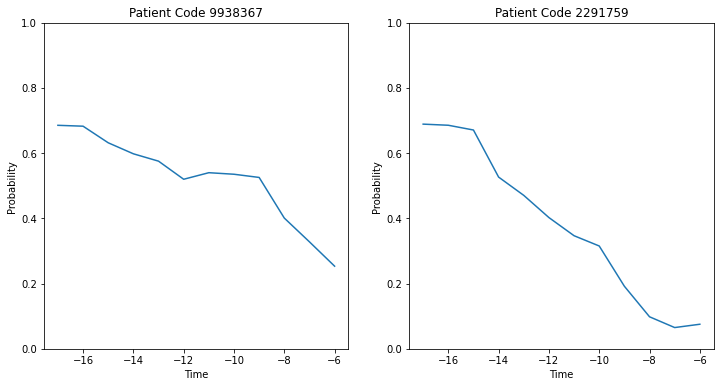

In [ ]:
time = [-17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6]
fig = plt.figure(figsize = (12, 6))

plt1 = fig.add_subplot(1,2,1)
plt1.set_title('Patient Code ' + str(int(rolling[selected_rolling[0]][13])))
plt1.set_xlabel('Time')
plt1.set_ylabel('Probability')
plt1.plot(time, rolling[selected_rolling[0]][0:12])
plt1.set_ylim(0,1)

plt2 = fig.add_subplot(1,2,2)
plt2.set_title('Patient Code ' + str(int(rolling[selected_rolling[1]][13])))
plt2.set_xlabel('Time')
plt2.set_ylabel('Probability')
plt2.plot(time, rolling[selected_rolling[1]][0:12])
plt2.set_ylim(0,1)



選出一直都很低，且最後真的沒有AKI的病人

In [4]:
selected_rolling = []
check = 0
for i in range(len(rolling)):
    if int(rolling[i][12]) == 0:
      check = 0
      for j in range(12):
          if rolling[i][j] < 0.4:
              check += 1
      if check == 12:
        print(rolling[i])
        selected_rolling.append(i)
print(selected_rolling)

[3.43425244e-01 3.03597242e-01 3.43471020e-01 3.03648770e-01
 3.43379974e-01 3.03451777e-01 3.43116701e-01 3.03201616e-01
 3.42906773e-01 3.03048760e-01 3.42766821e-01 3.02999616e-01
 0.00000000e+00 1.43298060e+07]
[3.29849124e-01 2.91621596e-01 3.29959899e-01 2.91616023e-01
 3.29924881e-01 2.91530013e-01 3.29925537e-01 2.91504771e-01
 3.29858780e-01 1.99111119e-01 1.36400640e-01 9.07160714e-02
 0.00000000e+00 2.63417700e+06]
[3.37670565e-01 2.98438966e-01 3.37752670e-01 2.98463136e-01
 3.37832332e-01 2.98526824e-01 3.37777913e-01 2.98476666e-01
 3.37573230e-01 2.98427492e-01 2.54583567e-01 1.50048167e-01
 0.00000000e+00 1.71065760e+07]
[3.60521168e-01 2.23501921e-01 2.19149083e-01 2.28932336e-01
 2.89506435e-01 2.39725769e-01 2.74052262e-01 2.64755309e-01
 3.26064676e-01 2.88156897e-01 3.25997710e-01 2.88062483e-01
 0.00000000e+00 1.91262350e+07]
[3.93779933e-01 3.62956107e-01 3.94001901e-01 3.63112003e-01
 3.94080549e-01 3.63139868e-01 3.94012868e-01 3.63013774e-01
 3.93778741e-01 3.

(0.0, 1.0)

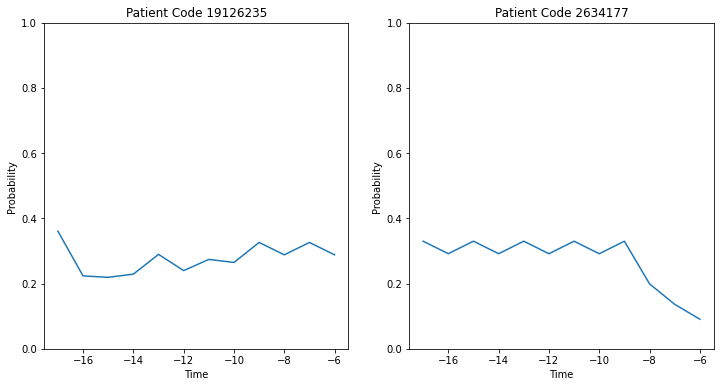

In [7]:
time = [-17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6]
fig = plt.figure(figsize = (12, 6))

plt1 = fig.add_subplot(1,2,1)
plt1.set_title('Patient Code ' + str(int(rolling[selected_rolling[3]][13])))
plt1.set_xlabel('Time')
plt1.set_ylabel('Probability')
plt1.plot(time, rolling[selected_rolling[3]][0:12])
plt1.set_ylim(0,1)

plt2 = fig.add_subplot(1,2,2)
plt2.set_title('Patient Code ' + str(int(rolling[selected_rolling[1]][13])))
plt2.set_xlabel('Time')
plt2.set_ylabel('Probability')
plt2.plot(time, rolling[selected_rolling[1]][0:12])
plt2.set_ylim(0,1)


隨機選200個label 0的病人

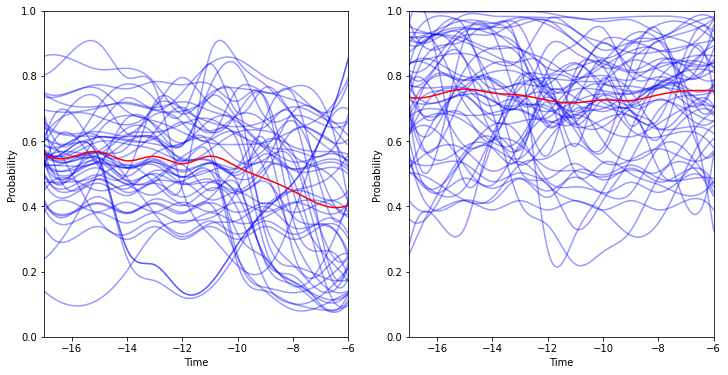

In [ ]:
time = [-17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6]
time = np.array(time)
fig = plt.figure(figsize = (12, 6))

prob = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
threshold = random.randint(0, 7)

count = 50
count_temp = count
selected_rolling = []
while count_temp >= 0:
    temp = random.randint(0, len(rolling)-1)
    threshold = random.randint(0, 9) / 10
    if rolling[temp][12] == 0 and rolling[temp][0] <= threshold:
      # 單筆
      selected_rolling.append(temp)
      count_temp -= 1
      # 多筆平均
      prob += rolling[temp][0:12]
prob = prob/count

plt1 = fig.add_subplot(1,2,1)
plt1.set_xlabel('Time')
plt1.set_ylabel('Probability')
plt1.set_xlim(-17,-6)
plt1.set_ylim(0,1)
x_new = np.linspace(time.min(),time.max(),300)
for index in range(0, count):
  y_smooth = make_interp_spline(time,rolling[selected_rolling[index]][0:12])(x_new)
  plt1.plot(x_new, y_smooth, 'b', alpha = 0.4)

y_smooth = make_interp_spline(time,prob)(x_new)
plt1.plot(x_new, y_smooth, 'r')
  



count = 50
count_temp = count
selected_rolling = []
while count_temp >= 0:
    temp = random.randint(0, len(rolling)-1)
    threshold = random.randint(0, 6) / 10
    if rolling[temp][12] == 1 and rolling[temp][11] >= threshold:
      # 單筆
      selected_rolling.append(temp)
      count_temp -= 1
      # 多筆平均
      prob += rolling[temp][0:12]
prob = prob/count

plt2 = fig.add_subplot(1,2,2)
plt2.set_xlabel('Time')
plt2.set_ylabel('Probability')
plt2.set_xlim(-17,-6)
plt2.set_ylim(0,1)
x_new = np.linspace(time.min(),time.max(),300)
for index in range(0, count):
  y_smooth = make_interp_spline(time,rolling[selected_rolling[index]][0:12])(x_new)
  plt2.plot(x_new, y_smooth, 'b', alpha = 0.4)

y_smooth = make_interp_spline(time,prob)(x_new)
plt2.plot(x_new, y_smooth, 'r')

In [ ]:
# time = [-17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6]
# time = np.array(time)
# fig = plt.figure(figsize = (12, 6))

# count = 100
# selected_rolling = []
# while count >= 0:
#     temp = random.randint(0, len(rolling)-1)
#     if rolling[temp][12] == 0:
#       selected_rolling.append(temp)
#       count -= 1
# print(selected_rolling)

# plt1 = fig.add_subplot(1,2,1)
# plt1.set_title('Label 0')
# plt1.set_xlabel('Time')
# plt1.set_ylabel('Probability')
# plt1.set_xlim(-17,-6)
# plt1.set_ylim(0,1)
# for index in range(0, 100):
#   x_new = np.linspace(time.min(),time.max(),300)
#   y_smooth = make_interp_spline(time,rolling[selected_rolling[index]][0:12])(x_new)
#   plt1.plot(x_new, y_smooth, 'b', alpha = 0.4)


# count = 100
# selected_rolling = []
# while count >= 0:
#     temp = random.randint(0, len(rolling)-1)
#     if rolling[temp][12] == 1:
#       selected_rolling.append(temp)
#       count -= 1
# print(selected_rolling)

# plt2 = fig.add_subplot(1,2,2)
# plt2.set_title('Label 1')
# plt2.set_xlabel('Time')
# plt2.set_ylabel('Probability')
# plt2.set_xlim(-17,-6)
# plt2.set_ylim(0,1)
# for index in range(0, 100):
#   x_new = np.linspace(time.min(),time.max(),300)
#   y_smooth = make_interp_spline(time,rolling[selected_rolling[index]][0:12])(x_new)
#   plt2.plot(x_new, y_smooth, 'b', alpha = 0.3)

### 計算最後1小準確度

In [ ]:
rolling = pd.read_csv("/content/drive/MyDrive/iirlab/topic/LSAN/LSANori/output/rp_result_with_patient_code.csv").to_numpy()
# rolling = pd.read_csv("/content/drive/MyDrive/iirlab/topic/LSAN/LSANori/output/rp_vlength_result_with_patient_code.csv").to_numpy()

In [ ]:
label = rolling[:,12]
temp = rolling[:,11]
prediction = []
for index in range(0, len(temp)):
  if temp[index] > 0.5:
    prediction.append(1)
  else:
    prediction.append(0)

tp = 0
fp = 0
tn = 0
fn = 0
for index in range(0, len(temp)):
  if label[index] == 1:
    if prediction[index] == 1:
      tp += 1
    else:
      fn += 1
  elif label[index] == 0:
    if prediction[index] == 1:
      fp += 1
    else:
      tn += 1

print("tp:{}, fp:{}, tn:{}, fn:{}".format(tp, fp, tn, fn ) )
# tp:3103, fp:916, tn:1551, fn:804
# tp:3200, fp:1636, tn:831, fn:707

tp:3103, fp:916, tn:1551, fn:804
